# Trist'n Joseph - IST 718 - Lab 1

## Introduction

"Paying coaches excessive compensation also makes less revenue available for other sports, causes many athletic departments to operate at a net loss, and may call into question the priorities of educational institutions."

While this is true, coaches should also be recognized for their hard work and should be compensated appropriately. Therefore, the question is, how does one appropriately recommend the optimal compensation for coaches?

There are many factors which could influence a coach's salary, and these factors could include (but are not limited to) the average salary within the city that the coach is working in; the number of years the coach has been in the business, along with their success metrics; the performance of the team; the school's budget for atheltics; the revenue that the team generates; and even the school's (or team's) academic performance.

Within this assignment, the goal is to ascertain how can one appropriately recommend the best salary for the next football coach. Through data analysis, I examine the relationships between factors which could influence a coach's salary to develop a model that can recommend an appropriate salary for new coaches.

## Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import chi2_contingency

## Data Manipulation

### Data Loading

In [2]:
# displaying all rows and columns
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [3]:
# loading and displaying a sample of the data
data_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST718/Labs/Lab 1/coachesdata.csv"
coaches_initial_df = pd.read_csv(data_path)
coaches_initial_df.head(10)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"
5,Arizona,Pac-12,Kevin Sumlin,"$1,600,000","$2,000,000","$2,025,000",--,$0,"$10,000,000"
6,Arizona State,Pac-12,Herm Edwards,"$2,000,000","$2,000,000","$3,010,000",--,$0,"$8,166,667"
7,Arkansas,SEC,Chad Morris,"$3,500,000","$3,500,000","$1,000,000",--,$0,"$12,500,000"
8,Arkansas State,Sun Belt,Blake Anderson,"$825,000","$825,000","$185,000","$25,000",$0,"$300,000"
9,Army,Ind.,Jeff Monken,932521,932521,--,--,$0,--


### Data Cleaning

In order for appropriate analysis to be conducted, data cleaning and transformation steps are necessary. These include removing string characters from columns that are numeric in nature, and exploring the data set for missing or inappropriate values.

In [4]:
# the '$' needs to be removed from columns
coaches_df = coaches_initial_df
coaches_df['SchoolPay'] = coaches_df['SchoolPay'].map(lambda x: x.replace('$', '').replace(',', ''))
coaches_df['TotalPay'] = coaches_df['TotalPay'].map(lambda x: x.replace('$', '').replace(',', ''))
coaches_df['Bonus'] = coaches_df['Bonus'].map(lambda x: x.replace('$', '').replace(',', ''))
coaches_df['BonusPaid'] = coaches_df['BonusPaid'].map(lambda x: x.replace('$', '').replace(',', ''))
coaches_df['AssistantPay'] = coaches_df['AssistantPay'].map(lambda x: x.replace('$', '').replace(',', ''))
coaches_df['Buyout'] = coaches_df['Buyout'].map(lambda x: x.replace('$', '').replace(',', ''))

In [5]:
# rows where the value is '--' should be removed since I am unable to acertain what the value should be (ie, these should be interpreted as null values)
coaches_df = coaches_df[coaches_df.SchoolPay != '--']
coaches_df = coaches_df[coaches_df.TotalPay != '--']
coaches_df = coaches_df[coaches_df.Bonus != '--']
coaches_df = coaches_df[coaches_df.BonusPaid != '--']
coaches_df = coaches_df[coaches_df.AssistantPay != '--']
coaches_df = coaches_df[coaches_df.Buyout != '--']

I chose to drop these rows because I am unable to determine what these values should be. For example, within the `BonusPaid` column, it cannot be determined that observations containing `--` should be converted to `0` since `0` is a value within that column. Therefore, a value of `0` indicates that 0 was contributed towards `BonusPaid`. Because of this, it would be inappropriate to assume that `--` also indicates 0 was contributed towards `BonusPaid`. Because of this ambiguity, it would be more appripriate to drop the unknown values.

In [6]:
# now, the values in the payment columns should be converted from strings to numerics
coaches_df['SchoolPay'] = coaches_df['SchoolPay'].astype(int)
coaches_df['TotalPay'] = coaches_df['TotalPay'].astype(int)
coaches_df['Bonus'] = coaches_df['Bonus'].astype(int)
coaches_df['BonusPaid'] = coaches_df['BonusPaid'].astype(int)
coaches_df['AssistantPay'] = coaches_df['AssistantPay'].astype(int)
coaches_df['Buyout'] = coaches_df['Buyout'].astype(int)

In [7]:
# converting the Conference from a string to a category
coaches_df['Conference'] = coaches_df['Conference'].astype('category')

In [8]:
# displaying the cleaned data set
coaches_df.head(5)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
1,Akron,MAC,Terry Bowden,411000,412500,225000,50000,0,688500
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000,500000,0,33600000
3,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000,165471,0,3847500
4,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000,145000,0,2160417
8,Arkansas State,Sun Belt,Blake Anderson,825000,825000,185000,25000,0,300000


### Data Transformation

In addition to understanding data regarding a coach's salary, supplemantary data could also be used to understand the various influences on salary.

Within this section, I gather and combine data regarding a team's stadium capacity, the school's graduation rate, and the team's most recent win-rate.

My hypothesis for the stadium capacity is that as a capacity increases, a team is able to generate more revenue per game since they can sell to more patrons. If the revenue increases, then it possible that the team has more available funds to compensate coaches.

In [9]:
# getting additional data
# -- retreving the stadium sizes
# --- most of the capacities were gathered from http://www.collegegridirons.com/comparisonscap.htm
stadium_capacity = [
    30000, 101821, 45000, 30000, 30964, 87451, 22500, 14500,
    23724, 25013, 56030, 30255, 74867, 26000, 81500, 21000,
    50183, 41000, 40000, 50000, 30200, 29571, 23500, 40727,
    92746, 71228, 4157, 30518, 40000, 60670, 52959, 70585,
    61000, 50071, 50000, 61000, 30600, 30427, 55000, 100500,
    38019, 54000, 44500, 62380, 24286, 107601, 75005, 31000,
    50805, 71004, 29993, 65000, 39224, 30343, 62980, 56919,
    30850, 24000, 24000, 102329, 84000, 60218, 20118, 106572,
    62500, 52454, 70561, 30456, 80250, 65857, 36000, 100119,
    30000, 60862, 72000, 26248, 30000, 45017, 25513, 61500,
    66233, 70138, 35117, 60000, 22113, 30200, 29181
]

analysis_df = coaches_df
analysis_df['stadium_capacity'] = stadium_capacity

My hypothesis for the graduation rate is that as the graduation rate increases, players on the team are more likely to have a good combination of athletics and academics, making them more favorable in the long run. As a team becomes more favorable, coaches might also become more favorable and could be compensated more due to the increased interest/higher demand.

In [10]:
# -- graduation rates
# --- data collected from https://web3.ncaa.org/aprsearch/gsrsearch
gsr = [
    88, 93, 89, 85, 82, 91, 90, 90,
    89, 89, 87, 61, 64, 35, 93, 88,
    93, 85, 92, 86, 46, 84, 84, 57,
    87, 81, 89, 85, 81, 91, 85, 89,
    92, 85, 92, 92, 78, 89, 91, 89,
    89, 86, 87, 93, 95, 94, 92, 93,
    94, 89, 85, 79, 79, 84, 81, 89,
    86, 87, 90, 88, 86, 82, 81, 92,
    88, 90, 86, 84, 95, 84, 84, 77,
    82, 80, 83, 92, 85, 94, 93, 95,
    91, 91, 87, 84, 82, 83, 91    
]

fgr = [
    65, 71, 64, 64, 60, 66, 72, 72,
    74, 68, 78, 95, 90, 65, 65, 57,
    66, 71, 72, 70, 93, 56, 58, 86,
    68, 62, 72, 62, 59, 74, 62, 71,
    72, 64, 72, 65, 57, 54, 69, 54,
    65, 67, 67, 61, 80, 81, 79, 61,
    82, 64, 61, 62, 54, 59, 55, 65,
    63, 64, 78, 74, 61, 60, 58, 78,
    74, 74, 70, 59, 70, 63, 55, 57,
    56, 54, 62, 75, 65, 71, 69, 78,
    67, 73, 66, 59, 58, 61, 67    
]

analysis_df['gsr'] = gsr
analysis_df['fgr'] = fgr

My hypothesis for the win rate is that as the team's win rate increases, the coach would become more favorable due to the team's dominance throought the season. Therefore, an increase in win rate should be associated with an increase in salary.

In [11]:
# -- win rates
# --- data collected from https://www.teamrankings.com/ncf/trends/win_trends
win_rate = [
    33.3, 83.3, 60.0, 80.0, 16.7, 66.7, 50.0, 50.0,
    33.3, 33.3, 20.0, 50.0, 66.7, 100.0, 60.0, 100.0,
    20.0, 40.0, 0.0, 50.0, 66.7, 50.0, 16.7, 66.7,
    100.0, 33.3, 50.0, 50.0, 83.3, 28.6, 40.0, 100.0,
    60.0, 20.0, 60.0, 100.0, 40.0, 40.0, 50.0, 50.0,
    50.0, 66.7, 16.7, 50.0, 33.3, 100.0, 100.0, 33.3,
    60.0, 50.0, 80.0, 0.0, 33.3, 14.3, 50.0, 80.0,
    20.0, 66.7, 16.7, 83.3, 100.0, 100.0, 16.7, 83.3,
    60.0, 50.0, 100.0, 50.0, 50.0, 20.0, 16.7, 66.7,
    40.0, 66.7, 66.7, 50.0, 50.0, 60.0, 60.0, 66.7,
    60.0, 40.0, 50.0, 33.3, 20.0, 66.7, 80.0    
]

analysis_df['win_rate'] = win_rate

In [12]:
# displaying the combined data set
analysis_df.head(5)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,stadium_capacity,gsr,fgr,win_rate
1,Akron,MAC,Terry Bowden,411000,412500,225000,50000,0,688500,30000,88,65,33.3
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000,500000,0,33600000,101821,93,71,83.3
3,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000,165471,0,3847500,45000,89,64,60.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000,145000,0,2160417,30000,85,64,80.0
8,Arkansas State,Sun Belt,Blake Anderson,825000,825000,185000,25000,0,300000,30964,82,60,16.7


## Data Analysis

### Main Analysis Question: `How can we recommend the best salary for the next head football coach?`

#### What is the total payment?

In [13]:
total_payment = analysis_df['TotalPay'].sum()
average_payment = analysis_df['TotalPay'].mean()
payment_statement = 'The total payment across all schools (all conferences) is ~${:,.2f}, '.format(total_payment) + 'and the average payment is ~${:,.2f}'.format(average_payment)
print(payment_statement)

The total payment across all schools (all conferences) is ~$200,447,095.00, and the average payment is ~$2,303,989.60


Most likely, however, the payment is not distrubuted equally nor normally. It is more likely that the distribution is skewed towards more coaches having a lower compensation.

#### What is the distribution of `TotalPay`?

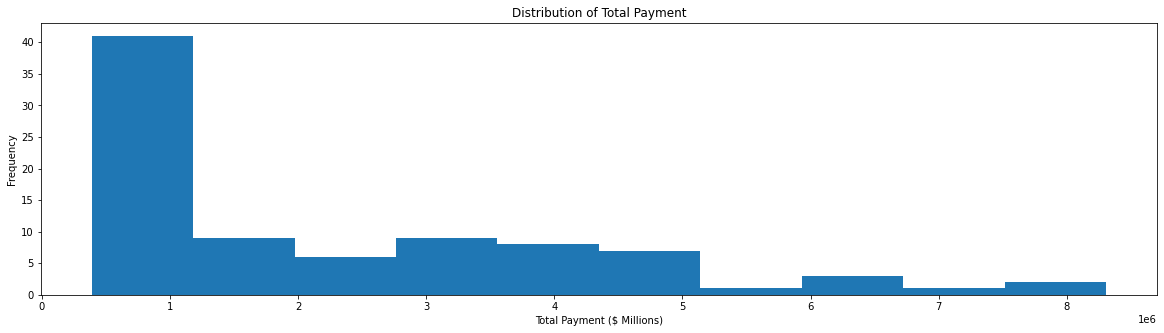

In [14]:
fig = plt.figure(figsize = (20, 5))
plt.hist(analysis_df['TotalPay'])
plt.ylabel('Frequency')
plt.xlabel('Total Payment ($ Millions)')
plt.title('Distribution of Total Payment')
plt.show()

As can be seen, there is neither an equal nor normal distribution to `TotalPay`. The histogram shows that there is a significantly large number of individuals receiving a low total payment.

It is possible that the payments are significantly different between `Conference`, but in terms of the average compensation and the spread of the compensation.

#### What are the payments like by `Conference`?

In [15]:
# Which Conference has the highest Average total pay?
avg_total_by_by_conference = analysis_df \
    .groupby('Conference') \
    .agg(
        average_TotalPay = pd.NamedAgg('TotalPay', 'mean'),
        standardDev_TotalPay = pd.NamedAgg('TotalPay', 'std'),
        average_Bonus = pd.NamedAgg('Bonus', 'mean'),
        average_BonusPaid = pd.NamedAgg('BonusPaid', 'mean'),
        average_Buyout = pd.NamedAgg('Buyout', 'mean'),
    ) \
    .sort_values('average_TotalPay', ascending=False)

# -- highest payments (on average)
avg_total_by_by_conference

,average_TotalPay,standardDev_TotalPay,average_Bonus,average_BonusPaid,average_Buyout
Conference,,,,,
SEC,5.097122e+06,2.130591e+06,1.535714e+06,442857.142857,1.930577e+07
Big Ten,4.353311e+06,1.911881e+06,1.167424e+06,164090.909091,1.489384e+07
Big 12,3.915323e+06,1.186319e+06,1.019375e+06,141562.500000,1.114661e+07
ACC,3.815543e+06,1.313236e+06,1.253988e+06,295702.428571,1.494152e+07
Pac-12,3.208783e+06,1.097170e+06,1.152000e+06,205233.400000,1.160545e+07
AAC,1.592083e+06,6.386909e+05,7.495833e+05,67333.333333,3.178301e+06
Mt. West,1.016932e+06,4.929589e+05,7.600000e+05,166454.545455,3.340035e+06
C-USA,8.517576e+05,2.472935e+05,4.980031e+05,43592.750000,2.792014e+06
Sun Belt,6.295000e+05,1.809008e+05,3.015476e+05,50714.285714,1.191101e+06


In [16]:
# -- most consistent payments
consistent_payments = avg_total_by_by_conference.sort_values('standardDev_TotalPay', ascending=True)
consistent_payments

,average_TotalPay,standardDev_TotalPay,average_Bonus,average_BonusPaid,average_Buyout
Conference,,,,,
Ind.,4.598200e+05,5.682310e+04,2.625000e+05,20000.000000,9.163950e+05
Sun Belt,6.295000e+05,1.809008e+05,3.015476e+05,50714.285714,1.191101e+06
MAC,5.926849e+05,2.131545e+05,3.721312e+05,52858.272727,1.172810e+06
C-USA,8.517576e+05,2.472935e+05,4.980031e+05,43592.750000,2.792014e+06
Mt. West,1.016932e+06,4.929589e+05,7.600000e+05,166454.545455,3.340035e+06
AAC,1.592083e+06,6.386909e+05,7.495833e+05,67333.333333,3.178301e+06
Pac-12,3.208783e+06,1.097170e+06,1.152000e+06,205233.400000,1.160545e+07
Big 12,3.915323e+06,1.186319e+06,1.019375e+06,141562.500000,1.114661e+07
ACC,3.815543e+06,1.313236e+06,1.253988e+06,295702.428571,1.494152e+07


[Text(0, 0.5, 'Total Payment ($ Millions)'),
 Text(0.5, 1.0, 'Distribution of Compensation by Conference')]

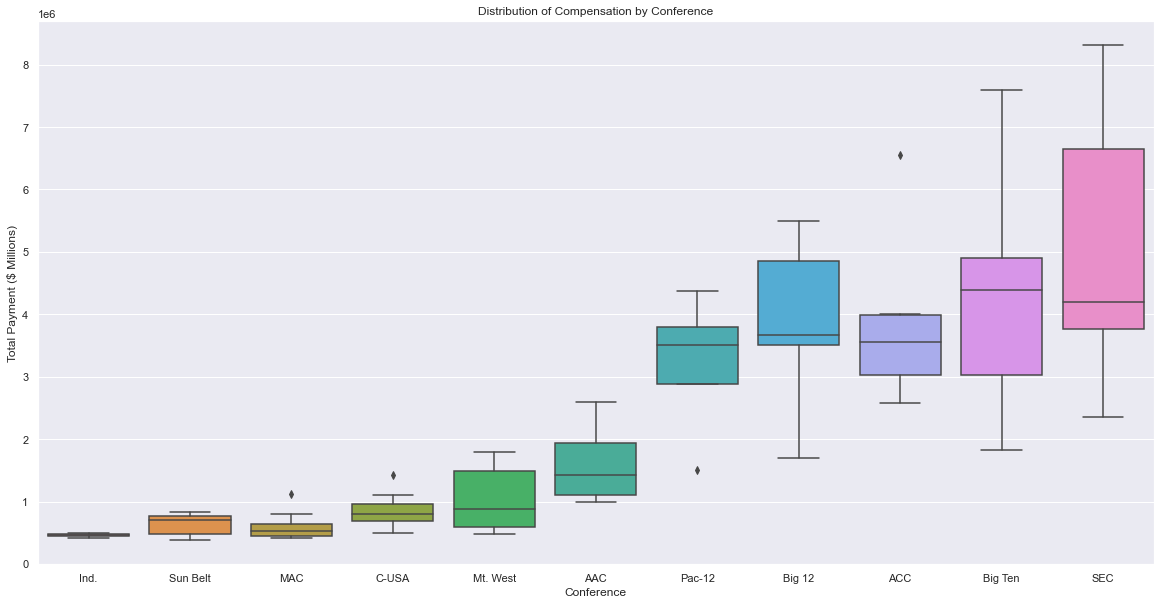

In [17]:
# plotting the distribution of TotalPay
sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.boxplot(x='Conference', y='TotalPay', data=analysis_df, order=consistent_payments.index)
ax.set(ylabel='Total Payment ($ Millions)', title='Distribution of Compensation by Conference')

The tables and boxplot above indicate that the SEC Conference pays the highest (on average) while the Ind Conference pays the lowest. However, the SEC also has the largest variation in payment. If an individual wanted less variation in their payment then the Ind Conference would be their best best.

To strike an optimal balance between high payment and low variation, and individual should go to the Pac-12 Conference.

#### Is there a significant relationship between `TotalPay` and `Conference`?

In [18]:
# conducting a Chi Squared test to determine the relationship betwen TotalPay and Conference
def assign_distribution_category(values):
    """
    This function accepts a list of values and bins the values into High, Medium and Low.
    The values are binned based on the range of the input values.
    """
    max_value = values.max()
    min_value = values.min()
    value_range = max_value - min_value
    one_third_value_range = value_range * (1/3)
    two_thirds_value_range = value_range * (2/3)
    
    category_list = []
    
    for value in values:        
        if value < one_third_value_range:
            category = 'Low'

        elif (value >= one_third_value_range) and (value < two_thirds_value_range):
            category = 'Medium'

        else:
            category = 'High'
            
        category_list.append(category)
        
    return category_list

In [19]:
analysis_df['TotalPay_Category'] = assign_distribution_category(analysis_df['TotalPay'])
analysis_df['TotalPay_Category'] = analysis_df['TotalPay_Category'].astype('category')

In [20]:
def run_chi2_test(var1, var2, alpha):
    """
    This function accepts 2 variables and an alpha level as inputs
    Conducts a Chi-Squared test on the input variables
    Returns a dictionary with the contingency table null hypothesis decision
    """    
    contingency_table = pd.crosstab(var1, var2)
    c, p, dof, expected = chi2_contingency(contingency_table)
    
    if p < alpha:
        H0_statement = 'The p-value is less than alpha; ie: ' + str(round(p, 4)) + ' < ' + str(alpha) + '. Therefore, there is enough statistical evidence to suggest that there is a relationship between the variables.'
        
    else:        
        H0_statement = 'The p-value is greater than alpha; ie: ' + str(round(p, 4)) + ' > ' + str(alpha) + '. Therefore, there is not enough statistical evidence to suggest that there is a relationship between the variables.'
        
    od = {'contingency_table': contingency_table, 'H0_decision': H0_statement}
    
    return od

In [21]:
run_chi2_test(analysis_df['TotalPay_Category'], analysis_df['Conference'], 0.05)['H0_decision']

'The p-value is less than alpha; ie: 0.0 < 0.05. Therefore, there is enough statistical evidence to suggest that there is a relationship between the variables.'

Based on the hypotheses previously stated, there is also a likely relationship between the `win_rate` and the `TotalPay`.

#### What is the relationship between `TotalPay` and `win_rate`?

In [22]:
analysis_df['win_rate_Category'] = assign_distribution_category(analysis_df['win_rate'])
analysis_df['win_rate_Category'] = analysis_df['win_rate_Category'].astype('category')
run_chi2_test(analysis_df['TotalPay_Category'], analysis_df['win_rate_Category'], 0.05)['H0_decision']

'The p-value is less than alpha; ie: 0.0051 < 0.05. Therefore, there is enough statistical evidence to suggest that there is a relationship between the variables.'

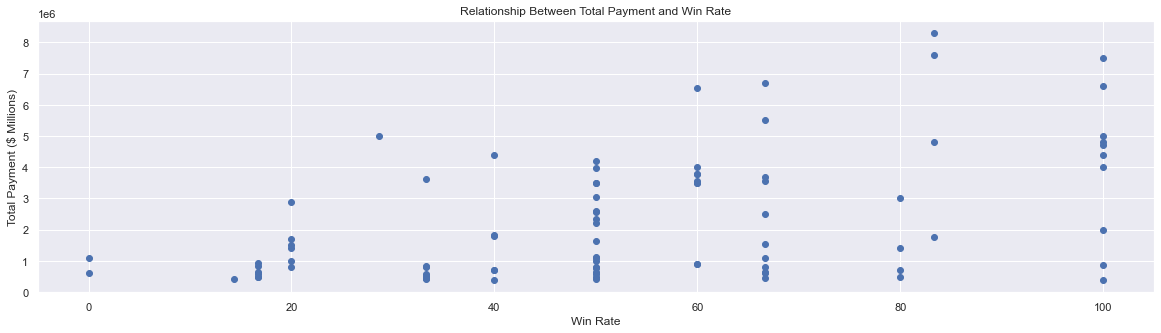

In [23]:
fig = plt.figure(figsize = (20, 5))
plt.scatter(analysis_df['win_rate'], analysis_df['TotalPay'])
plt.xlabel('Win Rate')
plt.ylabel('Total Payment ($ Millions)')
plt.title('Relationship Between Total Payment and Win Rate')
plt.show()

As can be seen, as the win rate increases, the total also payment increases.

[Text(0, 0.5, 'Total Payment ($ Millions)'),
 Text(0.5, 0, 'Win Rate Category'),
 Text(0.5, 1.0, 'Distribution of Compensation by Win Rate Category')]

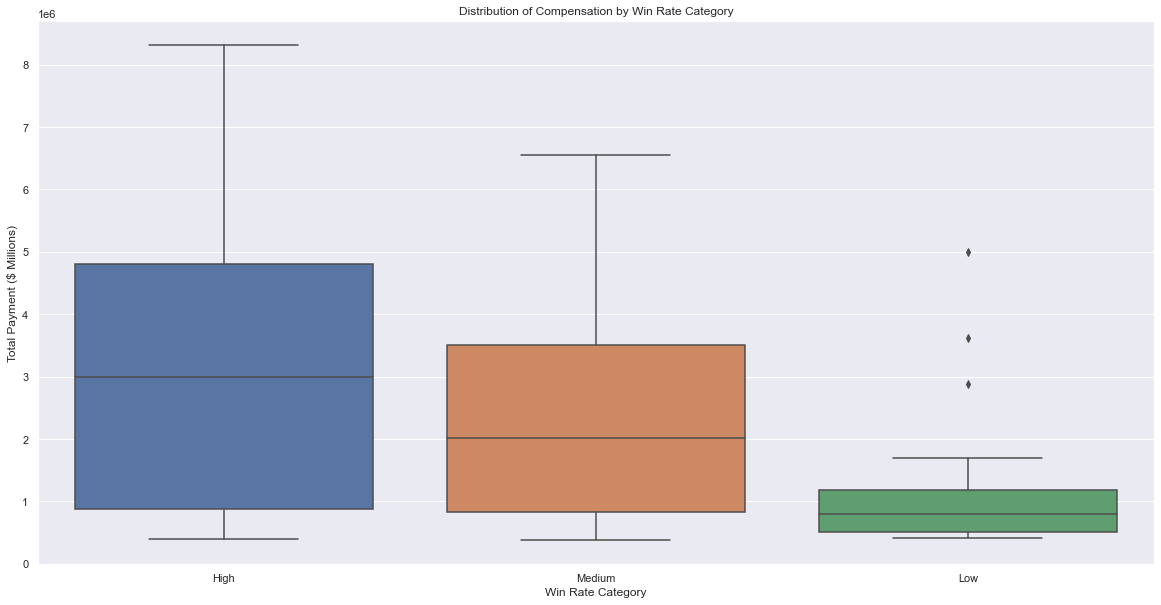

In [24]:
sns.set_theme(style='whitegrid')
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.boxplot(x='win_rate_Category', y='TotalPay', data=analysis_df, order=['High', 'Medium', 'Low'])
ax.set(ylabel='Total Payment ($ Millions)',xlabel='Win Rate Category', title='Distribution of Compensation by Win Rate Category')

The boxplot above shows that there is significant overlap for payment between all win rate categories. However, the key takeaway from this plot is that coaches should try to break out of the Low win rate category, as the variation in payment is small and the average payment is low (ie, they will be guaranteed a lower payment when compared to coaches in a Medium or High win rate).

#### What are the relatoinships between all variables?

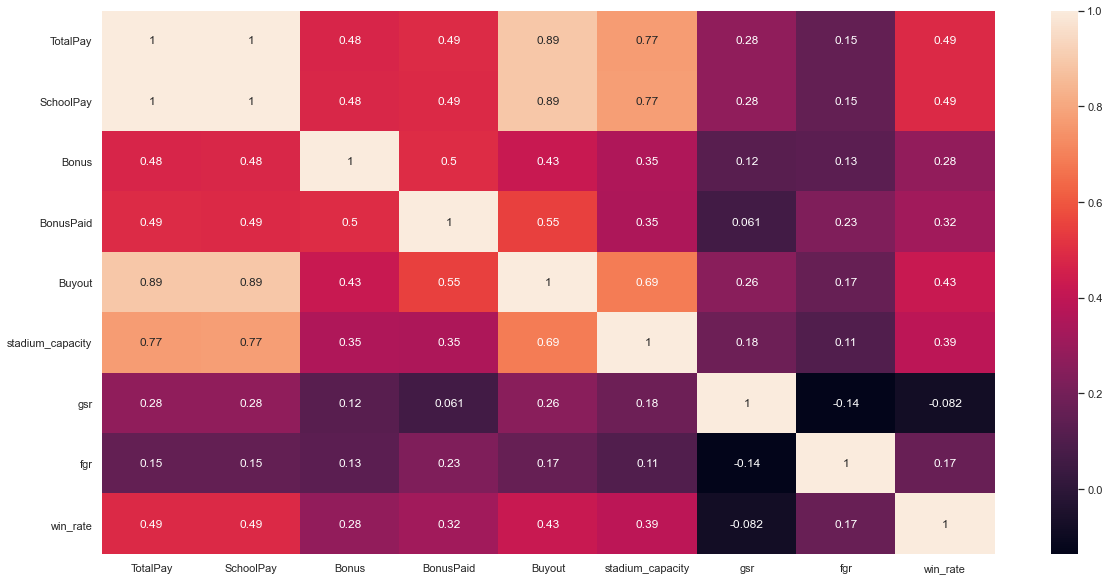

In [25]:
numerics_df = analysis_df[['TotalPay', 'SchoolPay', 'Bonus', 'BonusPaid', 'Buyout', 'stadium_capacity', 'gsr', 'fgr', 'win_rate']]

numberics_correlation_matrix = numerics_df.corr()
sns.heatmap(numberics_correlation_matrix, annot=True)
plt.show()

From the correlation matrix above, it can be inferred that the strongest relationship between any variable and `TotalPay` is with `Buyout`; `Buyout` has a relatively strong positive relationship with `TotalPay`. This indicates that as the `Buyout` increases, `TotalPay` also increases. 

There also also some instances of multicolinearity within the data set. Multicolinearity exists when there are relatively strong relationships between the predictor variables within the data set. An instance of this can be seen between `Buyout` and `stadium_capacity`; these variables have a moderately strong positive relationship.

When investigating linear models with these variables, it would be ideal to only include one of these variables (as compared to including both), since there would be significant overlap in what the measure in terms of `TotalPay` variation.

### Data Modeling

In [26]:
Y = analysis_df['TotalPay']
X_1 = analysis_df[['Conference', 'Bonus', 'BonusPaid', 'Buyout', 'stadium_capacity', 'gsr', 'fgr', 'win_rate']]
X_1 = pd.get_dummies(X_1, drop_first=True)

X_1 = sm.add_constant(X_1)
linear_model_1 = sm.OLS(Y, X_1).fit()
print(linear_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     45.04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.37e-30
Time:                        17:02:35   Log-Likelihood:                -1276.4
No. Observations:                  87   AIC:                             2589.
Df Residuals:                      69   BIC:                             2633.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.166e+05   1

The Adjusted R-Squared from this model indicates that ~89.7% of the variation in `TotalPay` can be explained by `Conference`, `Bonus`, `BonusPaid`, `Buyout`, `stadium_capacity`, `gsr`, `fgr` and `win_rate`.

Through analyzing the p-values at the 5% level of significance, the significant variables within the model are `Buyout`, `win_rate`, and `Conference`. 

In [27]:
# examining the model with only the significant variables
X_2 = analysis_df[['Conference', 'Buyout', 'win_rate']]
X_2 = pd.get_dummies(X_2, drop_first=True)

X_2 = sm.add_constant(X_2)
linear_model_2 = sm.OLS(Y, X_2).fit()
print(linear_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     62.17
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.20e-33
Time:                        17:02:35   Log-Likelihood:                -1280.2
No. Observations:                  87   AIC:                             2586.
Df Residuals:                      74   BIC:                             2619.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                8.291e+05   3

The Adjusted R-Squared from this model indicates that ~89.5% of the variation in `TotalPay` can be explained by `Conference`, `Buyout`, and `win_rate`. Although this is a slightly lower value than the previous model, this model has better performance since it preduces similar results with fewer inputs. Additionally, the variables within the model are statistically significant.

The coefficient on `Buyout` is `0.1256`, and this indicates that as the `Buyout` value increases by 1 unit, holding all the other variables within the model constant, the `TotalPay` is expected to increase by ~$0.1256.

The coefficient on `win_rate` is `7192.9584`, and this indicates that as the `win_rate` value increases by 1%, holding all the other variables within the model constant, the `TotalPay` is expected to increase by ~$7192.9584.

The coefficient on `Conference_ACC` is `6.809e+05`, and this indicates that if a team is in the ACC Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$6.809e+05 higher than the salary for a team in the AAC Conference.

The coefficient on `Conference_Big 12` is `1.23e+06`, and this indicates that if a team is in the Big 12 Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$1.23e+06 higher than the salary for a team in the AAC Conference.

The coefficient on `Conference_Big Ten` is `1.148e+06`, and this indicates that if a team is in the Big Ten Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$1.148e+06 higher than the salary for a team in the AAC Conference.

The coefficient on `Conference_C-USA` is `-6.02e+05`, and this indicates that if a team is in the C-USA Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$6.02e+05 lower than the salary for a team in the AAC Conference.

The coefficient on `Conference_Ind` is `-5.959e+05`, and this indicates that if a team is in the Ind Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$5.959e+05 lower than the salary for a team in the AAC Conference.

The coefficient on `Conference_MAC` is `-7.108e+05`, and this indicates that if a team is in the MAC Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$7.108e+05 lower than the salary for a team in the AAC Conference.

The coefficient on `Conference_Mt. West` is `-6.308e+05`, and this indicates that if a team is in the Mt West Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$6.308e+05 lower than the salary for a team in the AAC Conference.

The coefficient on `Conference_Pac-12` is `6.481e+05`, and this indicates that if a team is in the Pac-12 Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$6.481e+05 higher than the salary for a team in the AAC Conference.

The coefficient on `Conference_SEC` is `1.328e+06`, and this indicates that if a team is in the SEC Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$1.328e+06 higher than the salary for a team in the AAC Conference.

The coefficient on `Conference_Sun Belt` is `-7.192e+05`, and this indicates that if a team is in the Sun Belt Conference, holding all the other variables within the model constant, the coach can expect the salary to be ~$7.192e+05 lower than the salary for a team in the AAC Conference.

Although linear model 2 performs well, the Chi-squared test was conducted with a categoriezed win rate. Therefore, a model with the win rate categorized should be investigated.

In [28]:
X_3 = analysis_df[['Conference', 'Bonus', 'BonusPaid', 'Buyout', 'stadium_capacity', 'gsr', 'fgr', 'win_rate_Category']]
X_3 = pd.get_dummies(X_3, drop_first=True)

X_3 = sm.add_constant(X_3)
linear_model_3 = sm.OLS(Y, X_3).fit()
print(linear_model_3.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     41.63
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.16e-29
Time:                        17:02:35   Log-Likelihood:                -1276.7
No. Observations:                  87   AIC:                             2591.
Df Residuals:                      68   BIC:                             2638.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Through analyzing the p-values at the 5% level of significance, the significant variables within the model are `Buyout`, and `Conference`. 

In [29]:
# examining only the significant variables
X_4 = analysis_df[['Conference', 'Buyout']]
X_4 = pd.get_dummies(X_4, drop_first=True)

X_4 = sm.add_constant(X_4)
linear_model_4 = sm.OLS(Y, X_4).fit()
print(linear_model_4.summary())

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     63.97
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.58e-33
Time:                        17:02:35   Log-Likelihood:                -1283.1
No. Observations:                  87   AIC:                             2590.
Df Residuals:                      75   BIC:                             2620.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 1.17e+06   2

The Adjusted R-Squared from this model indicates that ~89% of the variation in `TotalPay` can be explained by `Conference`, and `Buyout`. 

The interpretaion of the coefficients within this model is similar to the interpretaion of the coefficients within linear model 2.

### Lab Questions and Answers

#### What is the recommended salary for the Syracuse football coach?

In [30]:
# looking at the row re: Syracuse
coaches_initial_df[coaches_initial_df['School'] == 'Syracuse']

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
102,Syracuse,ACC,Dino Babers,2401206,2401206,--,--,0,--


In [31]:
# using linear_model_2 as it was the best model -- having highest Adjusted R-Squared and significant variables:
# -- assume Buyout = 0
Syracuse_coach_salary_lm2 = (8.291e+05) + (0.1256 * 0) + (7192.9584 * 42.9) + (6.809e+05)
print('The recommended salary for the Syracuse football coach is ~${:,.2f}, assuming that the school had a previous win rate of 42.9% and that the buyout was $0.00'.format(Syracuse_coach_salary_lm2))

The recommended salary for the Syracuse football coach is ~$1,818,577.92, assuming that the school had a previous win rate of 42.9% and that the buyout was $0.00


#### What would be the salary be if Syracuse was still in the `Big East`?

In [32]:
# using linear_model_2 as it was the best model -- having highest Adjusted R-Squared and significant variables:
# -- NB: Big East is now called the American Athletic Conference (AAC)
# -- assume Buyout = 0
Syracuse_coach_salary_BigEast_lm2 = (8.291e+05) + (0.1256 * 0) + (7192.9584 * 42.9)
print('The recommended salary for the Syracuse football coach, if Syracuse was in the Best East, is ~${:,.2f}, assuming that the school had a previous win rate of 42.9% and that the buyout was $0.00'.format(Syracuse_coach_salary_BigEast_lm2))

The recommended salary for the Syracuse football coach, if Syracuse was in the Best East, is ~$1,137,677.92, assuming that the school had a previous win rate of 42.9% and that the buyout was $0.00


#### What would the salary be if Syracuse was in the `Big Ten`?

In [33]:
# using linear_model_2 as it was the best model -- having highest Adjusted R-Squared and significant variables:
# -- assume Buyout = 0
Syracuse_coach_salary_BigTen_lm2 = (8.291e+05) + (0.1256 * 0) + (7192.9584 * 42.9) + (1.148e+06)
print('The recommended salary for the Syracuse football coach, if Syracuse was in the Best East, is ~${:,.2f}, assuming that the school had a previous win rate of 42.9% and that the buyout was $0.00'.format(Syracuse_coach_salary_BigTen_lm2))

The recommended salary for the Syracuse football coach, if Syracuse was in the Best East, is ~$2,285,677.92, assuming that the school had a previous win rate of 42.9% and that the buyout was $0.00


#### What schools were dropped from the data and why?

In [34]:
dropped_schools = pd.merge(coaches_initial_df, coaches_df, how='left', on=['School'], indicator=True)
dropped_schools = dropped_schools[dropped_schools['_merge'] == 'left_only']
print(dropped_schools[['School']])

                  School
0              Air Force
5                Arizona
6          Arizona State
7               Arkansas
9                   Army
12                Baylor
14        Boston College
16         Brigham Young
19       Central Florida
28                  Duke
31               Florida
34         Florida State
37      Georgia Southern
48            Kent State
50               Liberty
52   Louisiana-Lafayette
60          Miami (Fla.)
66           Mississippi
67     Mississippi State
69                  Navy
70              Nebraska
79          Northwestern
80            Notre Dame
86                Oregon
87          Oregon State
89            Pittsburgh
91                  Rice
95         South Alabama
98   Southern California
99    Southern Methodist
101             Stanford
102             Syracuse
103            Tennessee
105            Texas A&M
106      Texas Christian
109        Texas-El Paso
113               Tulane
114                Tulsa
115                 UCLA


In [35]:
print(dropped_schools.shape[0], 'schools were dropped from the data')
print('These schools were dropped because it was not possible to infer the value of various columns')

42 schools were dropped from the data
These schools were dropped because it was not possible to infer the value of various columns


#### What effect does the graduation rate have on the projected salary?

The graduation rate can be found within linear model 1.

Linear model 1 predicts the salary using the Conference, Bonus, Bonus Paid, Buyout, stadium capacity, graduation rate, and win rate as predictor variables.

Within the model, the graduation rate has a coefficient of `5343.2350`. This means that as the graduation rate increases by 1%, holding all variables within the model constant, the expected salary increases ~$5343.235.
However, this coefficient was not found to be statistically significant at the 5% level of significance. 

#### How good is the model?

Using `linear_model_2`, the Adjusted R-Squared indicates that ~89.5% of the variation in `TotalPay` can be explained by `Conference`, `Buyout`, and `win_rate`. Although this is a slightly lower value than the previous model, this model has better performance since it preduces similar results with fewer inputs. Additionally, the variables within the model are statistically significant.

This performance is relatively good, considering the fact that there are multiple factors which could be used to determine a coache's salary. These variable include factors which might not be measurable, such as the coach's level of negotiation. Therefore, the fact that ~90% of variation can be captured through these variables is significant.

#### What is the single biggest impact on salary size?

Using `linear_model_2`:

The `Conference` has the single biggest impact on the salary size. Being in the `SEC` Conference gives coahces the largest boost to their potential salary, while being in the `Sun Belt` Conference reduces the potential salary the most.